In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

2025-06-02 18:11:00.630733: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 18:11:03.241514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 18:11:10.266804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataset Creation

In [2]:
label_map = {"no_event":0, "А":1, "Б":2, "В":3, "Г":4, "Д":5, "Е":6, "Ё":7, "Ж":8, "З":9, "И":10, "Й":11, "К":12, "Л":13, "М":14, "Н":15, "О":16, "П":17, "Р":18, "С":19, "Т":20, "У":21, "Ф":22, "Х":23, "Ц":24, "Ч":25, "Ш":26, "Щ":27, "Ъ":28, "Ы":29, "Ь":30, "Э":31, "Ю":32, "Я":33}

In [3]:
annot = pd.read_csv("/home/jupyter/datasphere/project/annotations.tsv", sep="\t")
annot.drop(columns=["user_id", "begin", "end", "height", "width", "length"], inplace=False)

annot["text"] = annot["text"].apply(lambda x: label_map[x])

In [4]:
train_df = annot[annot["train"] == True].drop("train", axis=1)

print(train_df.shape)

(3182, 8)


In [5]:
ROOT_DIR = "/home/jupyter/datasphere/project/processed"

In [6]:
def sample_frame_paths(video_dir, num_frames=8):

    all_frames = sorted([
        os.path.join(video_dir, fname)
        for fname in os.listdir(video_dir)
        if fname.endswith(".jpg")
    ])
    total = len(all_frames)

    boundaries = np.linspace(0, total-1, num_frames + 1, dtype=np.int32)

    return [all_frames[i] for i in boundaries[1:]]

In [7]:
def load_and_preprocess(path):
    
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    return tf.cast(img, tf.float32) / 255.0


In [8]:
def load_video(path, label):
        
    frame_paths = sample_frame_paths(path)

    frames = []
    for p in frame_paths:
        frames.append(load_and_preprocess(p))
    # frames.shape == (8, 224, 224, 3)
    frames = tf.stack(frames)
    return frames, label


In [9]:
def video_generator(df):
    
    list_video_dirs = df['attachment_id'].apply(lambda x: os.path.join(ROOT_DIR, x)).tolist()
    list_labels = tf.one_hot(df['text'].astype(np.int32).tolist(), 34)
    for path, label in zip(list_video_dirs, list_labels):
        frames, _ = load_video(path, label)
        yield frames, label


def create_dataset(df, batch_size=8, augment=False, shuffle=False):

    dataset = tf.data.Dataset.from_generator(
        lambda: video_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(8, 224, 224, 3)),
            tf.TensorSpec(shape=(34,), dtype=tf.float32)
        ))
    
    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

### Model Loading

In [10]:
num_segments=8
num_classes=34

model = tf.keras.models.load_model('mobile_tsm_bukva2')

2025-06-02 18:11:24.053127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-02 18:11:31.481693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,56,56,144]
	 [[{{node x}}]]
2025-06-02 18:11:31.489455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,56,56,144]
	 [[{{node Placeholder}}]]
2025-06-02 18:11:31.563181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate a

### Conversion

In [11]:
def representative_data_gen():
    
    dataset = create_dataset(train_df, batch_size=1)
    for input_batch, _ in dataset.take(len(train_df)):
        yield [input_batch]


In [12]:
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 8, 224, 224, 3])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_quantizer = True
converter.experimental_new_converter = True
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS 
]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()

with open('mobilenetv2-tsm-uint8.tflite', 'wb') as f:
    f.write(tflite_quant_model)


2025-06-02 18:11:32.472750: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-06-02 18:11:32.472967: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2025-06-02 18:11:34.916118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-06-02 18:11:34.916184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-06-02 18:11:36.133281: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2116] Estimated count of arithmetic ops: 4.848 G  ops, equivalently 2.424 G  MACs
2025-06-02 18:11:36.357731: I tensorflow/core/common_runtime/executor.cc:1197]

### Evaluating TFLite Model

#### Dataset Creation

In [13]:
test_df = annot[annot["train"] == False].drop("train", axis=1)
test_df.shape

(680, 8)

In [14]:
def sample_frame_paths(video_dir, num_frames=8):

    all_frames = sorted([
        os.path.join(video_dir, fname)
        for fname in os.listdir(video_dir)
        if fname.endswith(".jpg")
    ])
    total = len(all_frames)

    boundaries = np.linspace(0, total-1, num_frames + 1, dtype=np.int32)

    return [all_frames[i] for i in boundaries[1:]]

In [15]:
def load_and_preprocess(path):
    
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    return tf.cast(img, dtype=tf.uint8)

In [16]:
def load_video(path, label):
    
    frame_paths = sample_frame_paths(path)

    frames = []
    for p in frame_paths:
        frames.append(load_and_preprocess(p))
    # frames.shape == (8, 224, 224, 3)
    frames = tf.stack(frames)
    return frames, label


In [17]:
def video_generator(df):
    
    list_video_dirs = df['attachment_id'].apply(lambda x: os.path.join(ROOT_DIR, x)).tolist()
    list_labels = tf.one_hot(df['text'].astype(np.int32).tolist(), 34)
    for path, label in zip(list_video_dirs, list_labels):
        frames, _ = load_video(path, label)
        yield frames, label

def create_validation_dataset(df, batch_size=8, augment=False, shuffle=False):

    dataset = tf.data.Dataset.from_generator(
        lambda: video_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(8, 224, 224, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(34,), dtype=tf.uint8)
        ))
    
    dataset = dataset.batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [18]:
def get_actual_predicted_labels(dataset):

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    actual = test_df["text"].to_list()
    predicted_labels = []

    for batch in dataset:
        single_sample = batch[0]
        
        #print(single_sample)
            
        interpreter.set_tensor(input_details[0]['index'], single_sample)
            
        interpreter.invoke()
            
        output = interpreter.get_tensor(output_details[0]['index'])
            
        predicted_label = np.argmax(output, axis=1)[0]
        predicted_labels.append(predicted_label)
    
    actual = tf.stack(actual, axis=0)
    predicted = tf.convert_to_tensor(predicted_labels)
    
    return actual, predicted

In [19]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    fig = ax.get_figure()
    fig.savefig("out.png") 

In [20]:
batch_size = 1

valid_ds = create_validation_dataset(test_df, batch_size)

#### Confusion Matrix

In [21]:
interpreter = tf.lite.Interpreter(model_path="mobilenetv2-tsm-uint8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print(input_details[0]['shape'])

[  1   8 224 224   3]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
actual, predicted = get_actual_predicted_labels(valid_ds)

2025-06-02 19:27:08.055816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


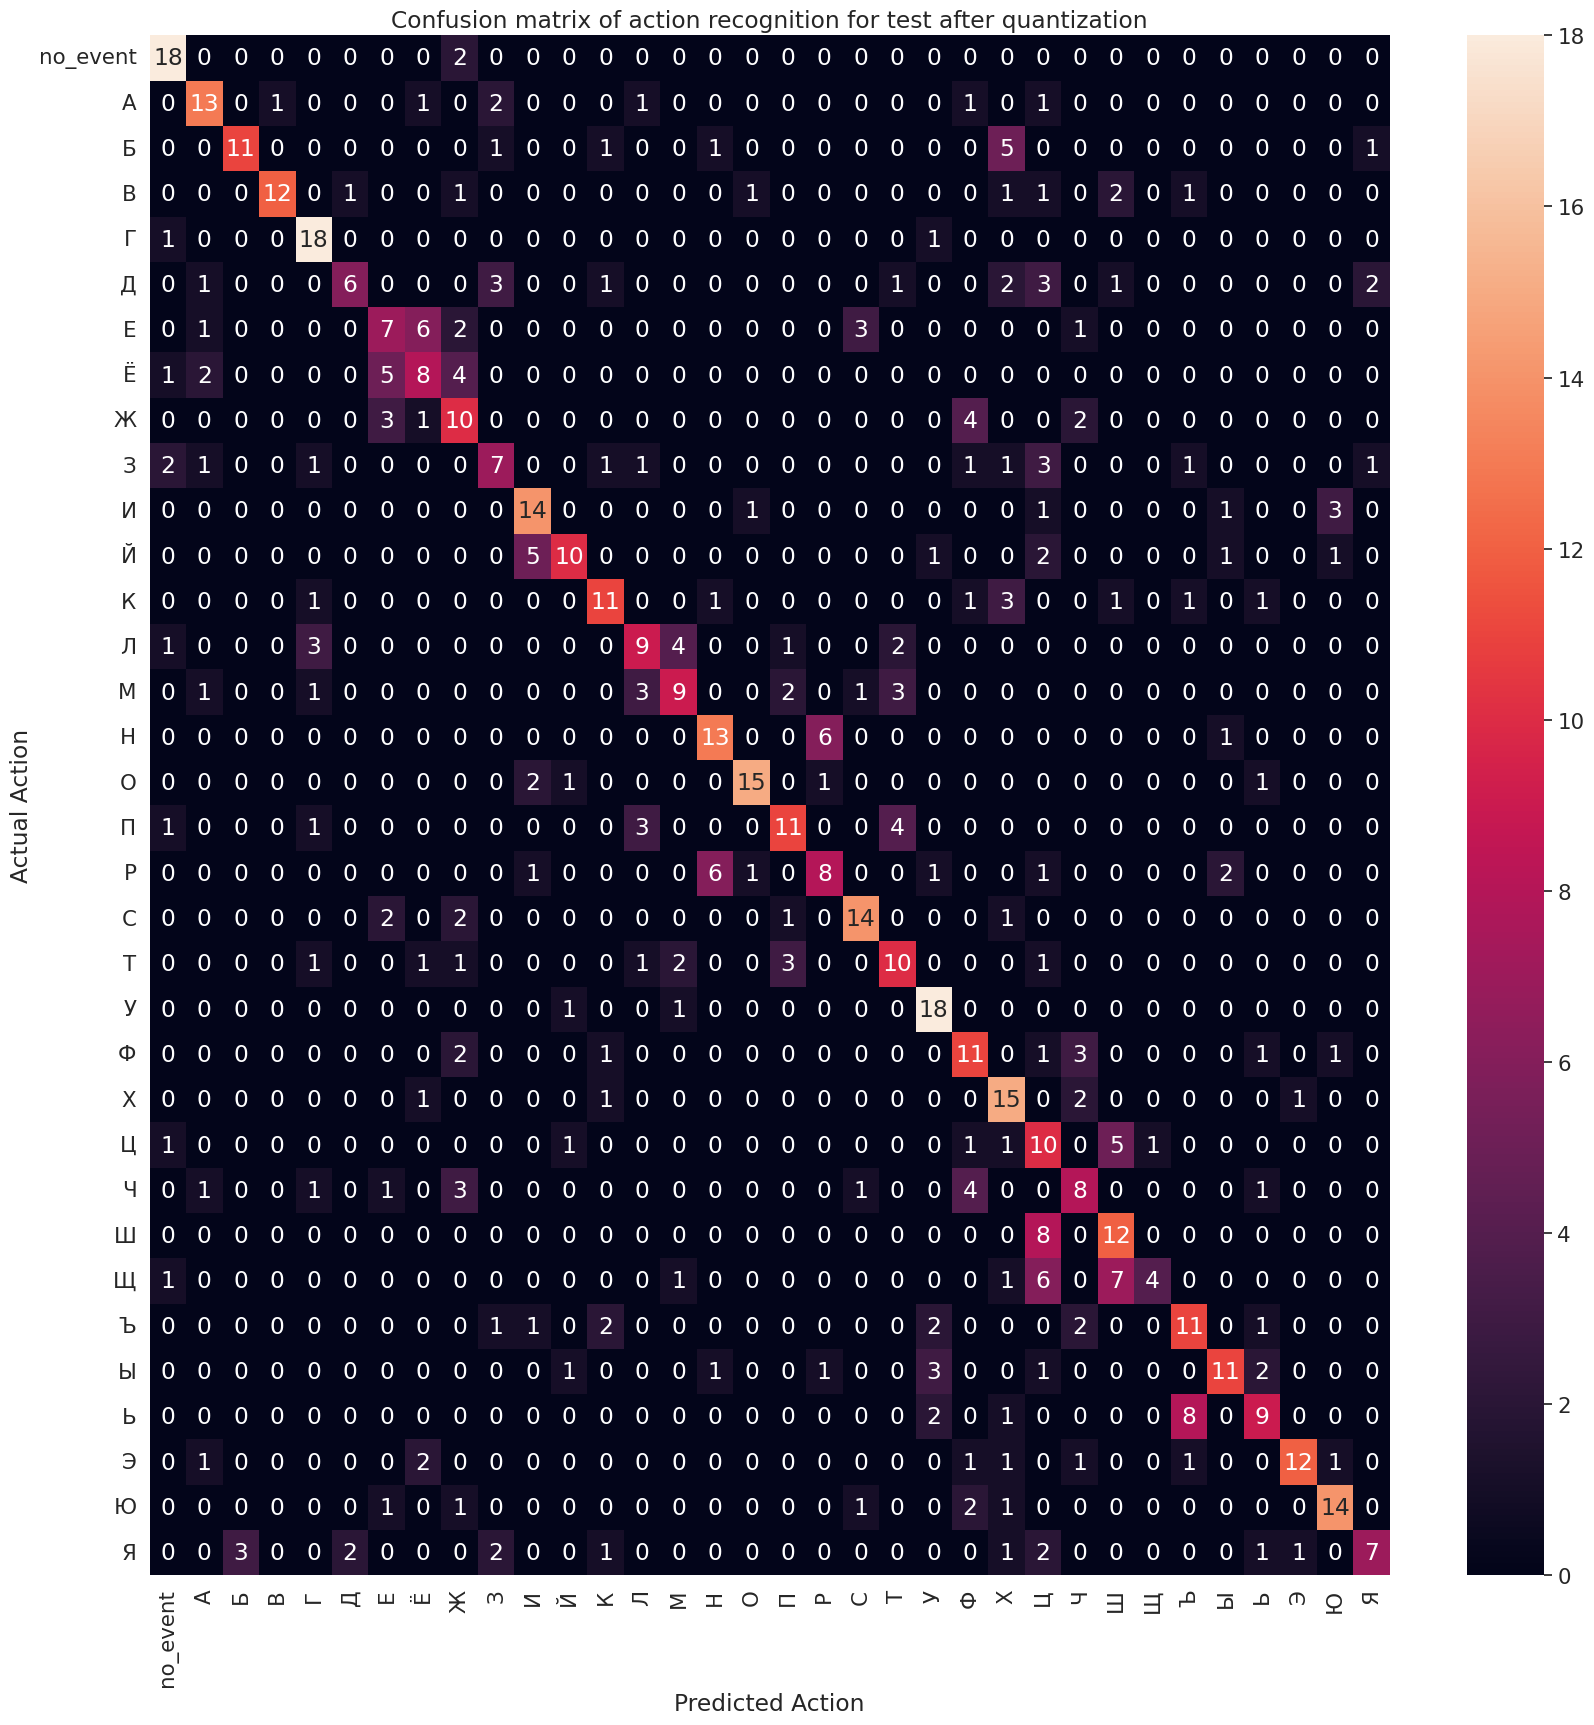

In [24]:
plot_confusion_matrix(actual, predicted, list(label_map.keys()), 'test after quantization')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
test_accuracy = accuracy_score(predicted, actual)
print(f'Accuracy on test data after quantization: {test_accuracy}')

In [ ]:
print(classification_report(actual, predicted, target_names=list(label_map.keys())))